# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [8]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stop= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:12<00:00, 1210.23it/s]


In [17]:
preprocessed_reviews[12126]

'number different switch juice flavors tried kiwi berry like whole lot kiwi though natural products meaning not man made guess counted things besides kiwi reviewers also pointed carbonated brings flavor bit opinion sweet yet say no sugars added however natural products concoction already sugar fluid ounce aluminum pop top calories carbs flavor good liked sensation drank marketing tall narrow pretty pink labeled want not makes feel like product calling saying buy premium product well sorry not buy juice product think term would preppy still taste good'

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying Random Forests

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scikitplot.metrics import plot_confusion_matrix
from wordcloud import WordCloud


In [20]:
y = np.array(final["Score"])


In [23]:
x,x_test,y,y_test = train_test_split(preprocessed_reviews, score, test_size = 0.2)
x_train,x_cv,y_train,y_cv = train_test_split(x,y,test_size = 0.2)
print(len(x_train), y_train.shape[0], sep = '  ')
print(len(x_cv), y_cv.shape[0], sep = '  ')
print(len(x_test),y_test.shape[0], sep = '  ')

56174  56174
14044  14044
17555  17555


In [96]:
from tqdm.notebook import tqdm
def train(x_tr,x_cross,x_tst):
    train_scores = []
    cv_scores = []
    estimators = [50,100,150,200,250,300,400,500]
    #finding best n_estiamtors
    for e in tqdm(estimators):
        clf = RandomForestClassifier(n_estimators=e,n_jobs=-1,class_weight='balanced')
        clf.fit(x_tr, y_train)
        cv_proba = clf.predict_proba(x_cross)
        train_proba = clf.predict_proba(x_tr)
        train_score = roc_auc_score(y_train,train_proba[:,1])
        train_scores.append(train_score)
        cv_score = roc_auc_score(y_cv, cv_proba[:,1])
        cv_scores.append(cv_score)
        print("AUC score on %d estimators for train data is %f and cross_validation data is %f"%(e,train_score,cv_score))
        
    optimal_estimators = estimators[cv_scores.index(max(cv_scores))]
    
    #plotting AUC scores
    sns.set_style("whitegrid")
    plt.plot(estimators,train_scores,label = "Train AUC Scores")
    plt.plot(estimators, cv_scores,label= "CV AUC Scores")
    plt.title("AUC scores for train and Cross_Validation Data")
    plt.xlabel("estimators")
    plt.ylabel("AUC scores")
    plt.legend()
    plt.show()
    
    return optimal_estimators

    
        

In [97]:
def test(x_tr,x_tst, optimal_estimators):
    clf = RandomForestClassifier(n_estimators = optimal_estimators , n_jobs = -1, class_weight = 'balanced')
    clf.fit(x_tr,y_train)
    
    train_proba = clf.predict_proba(x_tr)
    test_proba = clf.predict_proba(x_tst)
    test_score = roc_auc_score(y_test, test_proba[:,1])
    train_score = roc_auc_score(y_train, train_proba[:,1])
    fpr,tpr,thresholds = roc_curve(y_test,test_proba[:,1])
    fpr1,tpr1,thresholds = roc_curve(y_train, train_proba[:,1])
    
    print("Train data AUC score ", train_score)
    print("Test data AUC score", test_score)
    
    # plotting ROC curve
    #plot no skill
    sns.set_style("whitegrid")
    plt.plot([0,1],[0,1],'b--')
    plt.plot(fpr,tpr,label = "Test ROC curve" + str(test_score))
    plt.plot(fpr1, tpr1, label = "Train ROC curve" + str(train_score))
    plt.title("ROC curve for train and test data")
    plt.ylabel("True Postive Rates")
    plt.xlabel("False Positive Rates")
    plt.legend()
    plt.show()
    
    #plotting confusion matrix
    y_pred = clf.predict(x_tst)
    plot_confusion_matrix(y_test,y_pred,cmap = "Greens", figsize = (6,6))
    plt.title("test data confusion matrix")
    plt.show()
    
    

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [28]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df = 10, max_features=10000)
train_bow = count_vect.fit_transform(x_train)
cv_bow = count_vect.transform(x_cv)
test_bow = count_vect.transform(x_test)

std = StandardScaler(with_mean=False)
train_bow = std.fit_transform(train_bow)
cv_bow = std.transform(cv_bow)
test_bow = std.transform(test_bow)

print(type(train_bow))

<class 'scipy.sparse.csr.csr_matrix'>


AUC score on 50 estimators for train data is 0.999996 and cross_validation data is 0.928177
AUC score on 100 estimators for train data is 0.999997 and cross_validation data is 0.934128
AUC score on 150 estimators for train data is 0.999997 and cross_validation data is 0.935350
AUC score on 200 estimators for train data is 0.999997 and cross_validation data is 0.936209
AUC score on 250 estimators for train data is 0.999998 and cross_validation data is 0.936970
AUC score on 300 estimators for train data is 0.999997 and cross_validation data is 0.936270
AUC score on 400 estimators for train data is 0.999998 and cross_validation data is 0.936864
AUC score on 500 estimators for train data is 0.999998 and cross_validation data is 0.937565



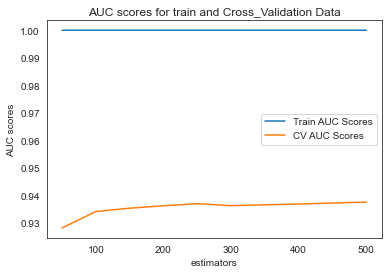

In [48]:
optimal_estimators = train(train_bow,cv_bow,test_bow)

Train data AUC score  0.9999975152387003
Test data AUC score 0.9429142651664066


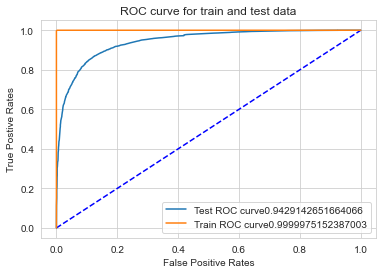

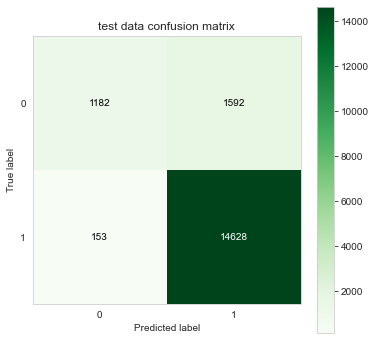

In [55]:
test(train_bow, test_bow, optimal_estimators)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [60]:
feature_names = count_vect.get_feature_names()
clf = RandomForestClassifier(n_estimators = optimal_estimators , n_jobs = -1, class_weight = 'balanced')
clf.fit(train_bow, y_train)
feat_importance = clf.feature_importances_
feat_dict = dict(zip(feat_importance,feature_names))
feat_importance = sorted(feat_importance, reverse = True)
importance = []
words = []
for imp in feat_importance[0:20]:
    words.append(feat_dict[imp])
    importance.append(imp) 

In [67]:
print("Top 20 features are :")
print("%30s\t%30s"%("feature_names","feature_importance"))
print('*'*100)
for i in range(20):
    print('%30s\t\t\t%.10f'%(words[i],importance[i]))


Top 20 features are :
                 feature_names	            feature_importance
****************************************************************************************************
                           not			0.0237697494
                         great			0.0220461855
                          best			0.0096703263
                          love			0.0093717988
                     delicious			0.0092740434
                  disappointed			0.0081473875
                           bad			0.0063378444
                       perfect			0.0062511187
                          good			0.0057669458
                         loves			0.0055254711
                       not buy			0.0050650961
                         would			0.0045790384
                      favorite			0.0045186457
                         worst			0.0044172693
                         money			0.0043474236
                     would not			0.0042836696
                         awful			0.0041940780
                          nice			

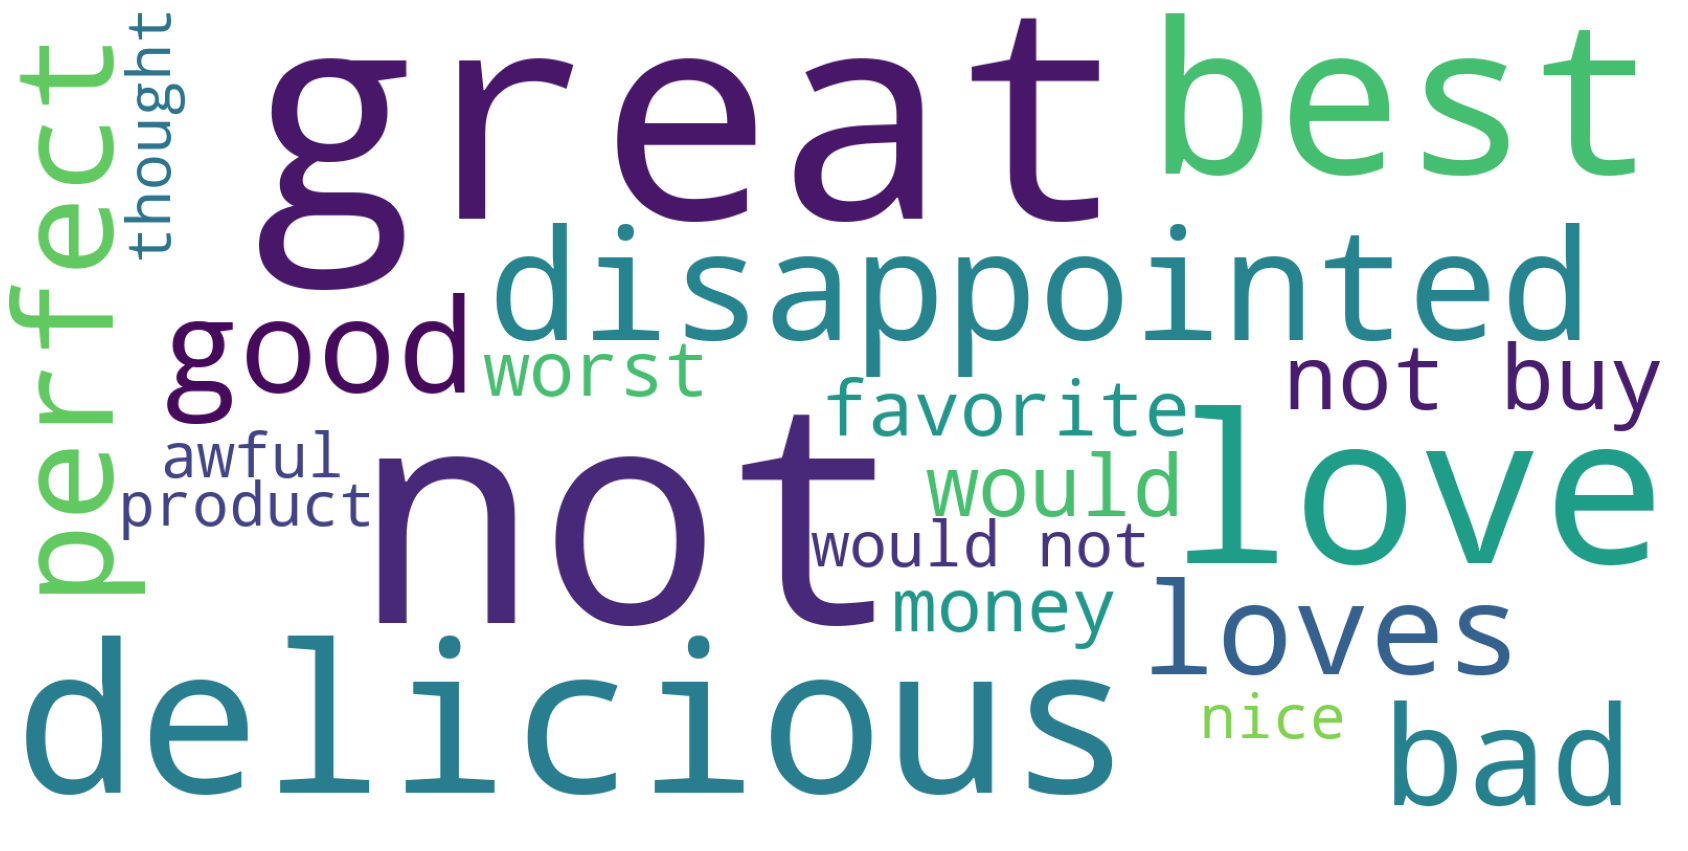

In [93]:

img = WordCloud(background_color = 'white',width = 1600, height = 800, stopwords=[])
img.fit_words(dict(zip(words,importance)))
plt.figure(figsize = (30,20))
plt.axis("off")
plt.imshow(img)
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [94]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df= 10, max_features = 10000)
train_tfidf = tfidf_vect.fit_transform(x_train)
cv_tfidf = tfidf_vect.transform(x_cv)
test_tfidf = tfidf_vect.transform(x_test)

AUC score on 50 estimators for train data is 0.999996 and cross_validation data is 0.929153
AUC score on 100 estimators for train data is 0.999997 and cross_validation data is 0.935130
AUC score on 150 estimators for train data is 0.999997 and cross_validation data is 0.937228
AUC score on 200 estimators for train data is 0.999997 and cross_validation data is 0.938786
AUC score on 250 estimators for train data is 0.999997 and cross_validation data is 0.938783
AUC score on 300 estimators for train data is 0.999998 and cross_validation data is 0.939409
AUC score on 400 estimators for train data is 0.999998 and cross_validation data is 0.939345
AUC score on 500 estimators for train data is 0.999998 and cross_validation data is 0.939254



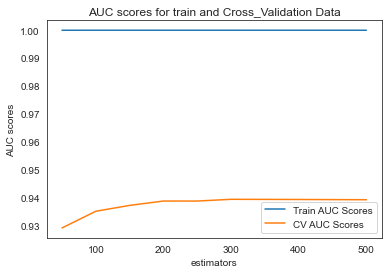

In [95]:
optimal_estimators = train(train_tfidf, cv_tfidf,test_tfidf)

Train data AUC score  0.9999975129044951
Test data AUC score 0.9436417940820868


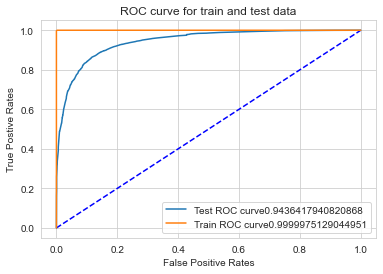

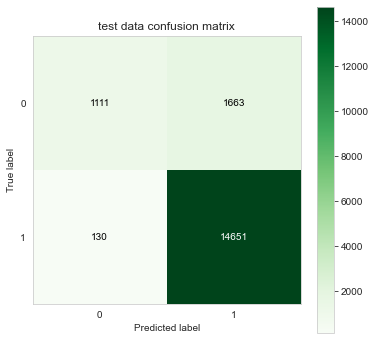

In [99]:
test(train_tfidf, test_tfidf, optimal_estimators)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [100]:
feature_names = tfidf_vect.get_feature_names()
clf = RandomForestClassifier(n_estimators = optimal_estimators , n_jobs = -1, class_weight = 'balanced')
clf.fit(train_tfidf, y_train)
feat_importance = clf.feature_importances_
feat_dict = dict(zip(feat_importance,feature_names))
feat_importance = sorted(feat_importance, reverse = True)
importance = []
words = []
for imp in feat_importance[0:20]:
    words.append(feat_dict[imp])
    importance.append(imp) 

In [101]:
print("Top 20 features are :")
print("%30s\t%30s"%("feature_names","feature_importance"))
print('*'*100)
for i in range(20):
    print('%30s\t\t\t%.10f'%(words[i],importance[i]))

Top 20 features are :
                 feature_names	            feature_importance
****************************************************************************************************
                           not			0.0273731921
                         great			0.0234175760
                          love			0.0111129076
                          best			0.0102013179
                     delicious			0.0096574058
                          good			0.0083594830
                  disappointed			0.0083380133
                       perfect			0.0067345373
                           bad			0.0065133039
                         loves			0.0061719359
                         would			0.0059783724
                      favorite			0.0052360844
                          nice			0.0047573620
                       thought			0.0046585756
                       not buy			0.0046455164
                     would not			0.0045479544
                         money			0.0043521362
                         worst			

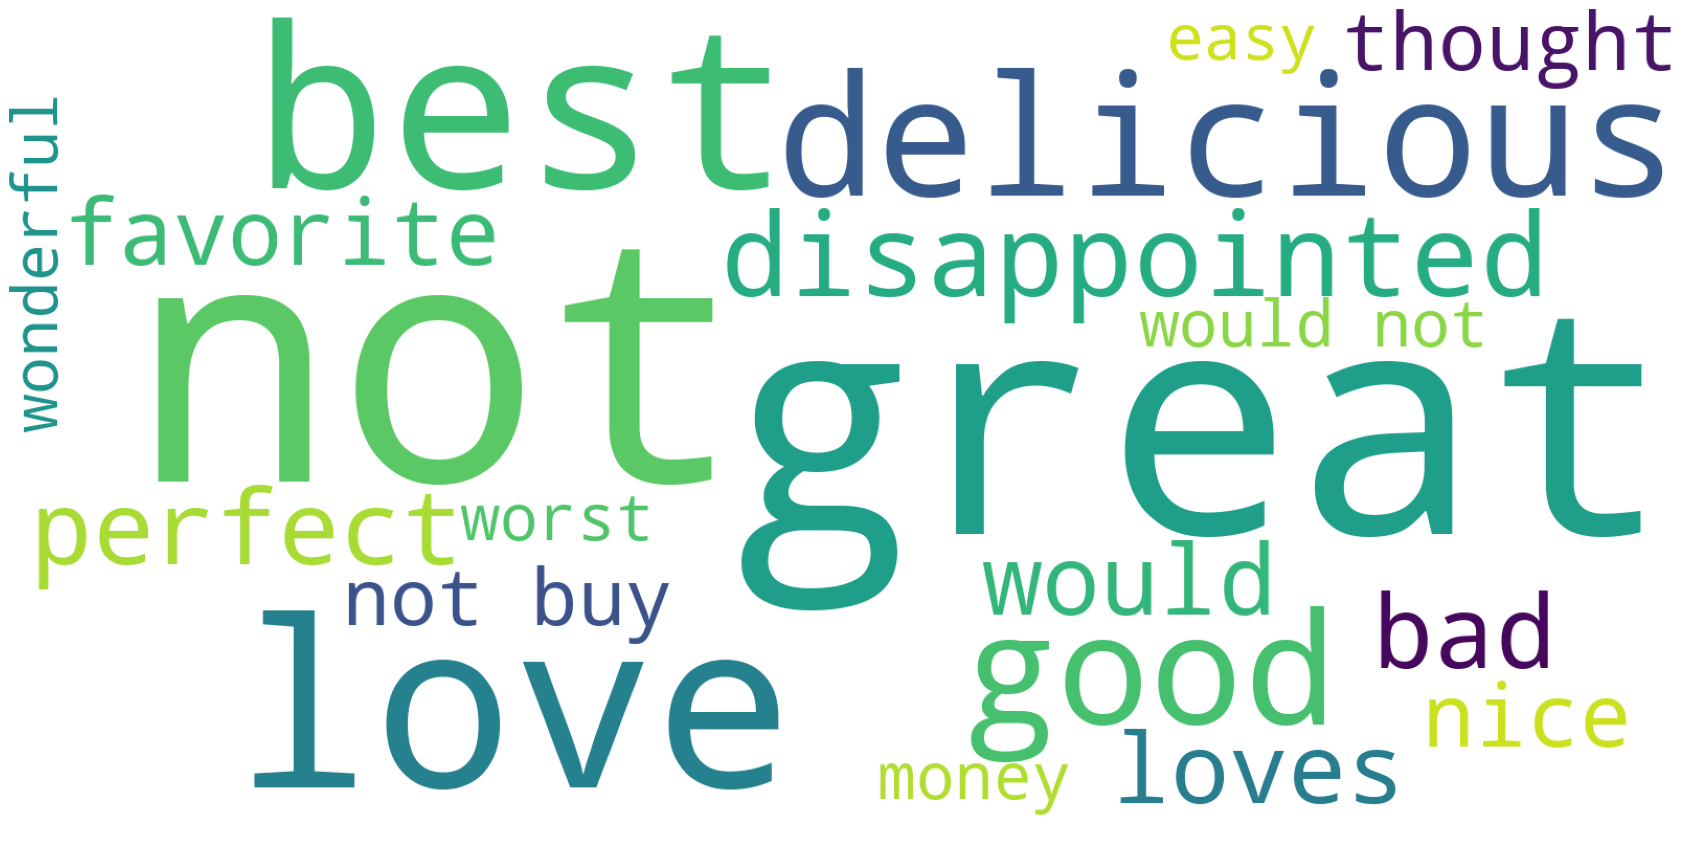

In [130]:
img = WordCloud(background_color = 'white',width = 1600, height = 800, stopwords=[])
img.fit_words(dict(zip(words,importance)))
plt.figure(figsize = (30,20))
plt.axis("off")
plt.imshow(img)
plt.show()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [103]:
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
        
w2v=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2vwords = list(w2v.wv.vocab)

In [105]:
w2v.most_similar("bad")

[('terrible', 0.7640166878700256),
 ('horrible', 0.7564935088157654),
 ('nasty', 0.7460595965385437),
 ('funny', 0.7421367168426514),
 ('awful', 0.7351542115211487),
 ('gross', 0.7346435189247131),
 ('disgusting', 0.7026392221450806),
 ('weird', 0.6901291608810425),
 ('realize', 0.6883422136306763),
 ('ok', 0.6854040026664734)]

In [106]:
def avgw2v(sentances):
    list_of_sentance=[]
    for sentance in sentances:
        list_of_sentance.append(sentance.split())
    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    
    for sent in tqdm(list_of_sentance, position = 0): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2vwords:
                vec = w2v.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors
    

In [107]:
train_w2v = avgw2v(x_train)
cv_w2v = avgw2v(x_cv)
test_w2v = avgw2v(x_test)

AUC score on 50 estimators for train data is 0.999990 and cross_validation data is 0.893175
AUC score on 100 estimators for train data is 0.999997 and cross_validation data is 0.899933
AUC score on 150 estimators for train data is 0.999996 and cross_validation data is 0.900695
AUC score on 200 estimators for train data is 0.999998 and cross_validation data is 0.901538
AUC score on 250 estimators for train data is 0.999997 and cross_validation data is 0.903204
AUC score on 300 estimators for train data is 0.999997 and cross_validation data is 0.903949
AUC score on 400 estimators for train data is 0.999998 and cross_validation data is 0.902737
AUC score on 500 estimators for train data is 0.999998 and cross_validation data is 0.903159



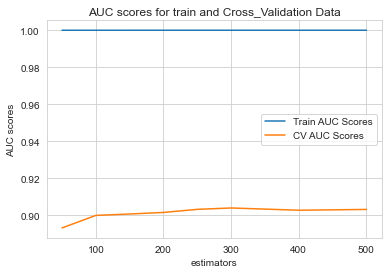

In [108]:
optimal_estimators = train(train_w2v, cv_w2v,test_w2v)

Train data AUC score  0.9999975164058028
Test data AUC score 0.8997603170187648


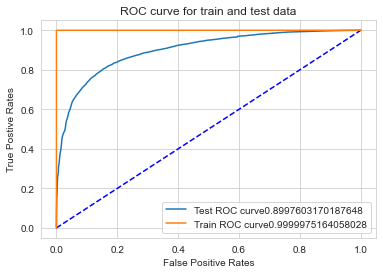

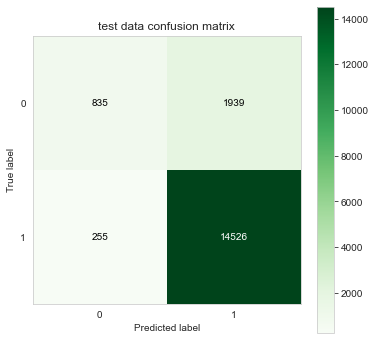

In [109]:
test(train_w2v, test_w2v, optimal_estimators)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [129]:
from tqdm.notebook import tqdm
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10,max_features= 10000)

tf_idf_matrix=tf_idf_vect.fit_transform(x_train)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#for cross validation data and test we will use same words and models of train
list_of_sentance_cv=[]
for sentance in tqdm(x_cv):
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

#for test data
list_of_sentance_test=[]
for sentance in tqdm(x_test):
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

AUC score on 50 estimators for train data is 0.999993 and cross_validation data is 0.867353
AUC score on 100 estimators for train data is 0.999997 and cross_validation data is 0.877319
AUC score on 150 estimators for train data is 0.999997 and cross_validation data is 0.880721
AUC score on 200 estimators for train data is 0.999997 and cross_validation data is 0.881582
AUC score on 250 estimators for train data is 0.999997 and cross_validation data is 0.883066
AUC score on 300 estimators for train data is 0.999997 and cross_validation data is 0.882144
AUC score on 400 estimators for train data is 0.999997 and cross_validation data is 0.884290
AUC score on 500 estimators for train data is 0.999997 and cross_validation data is 0.884111



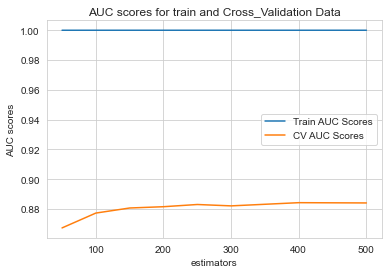

In [131]:
optimal_estimators = train(tfidf_sent_vectors_train,tfidf_sent_vectors_cv,tfidf_sent_vectors_test)

Train data AUC score  0.9999974358757279
Test data AUC score 0.878857039769337


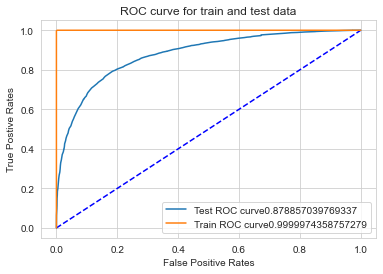

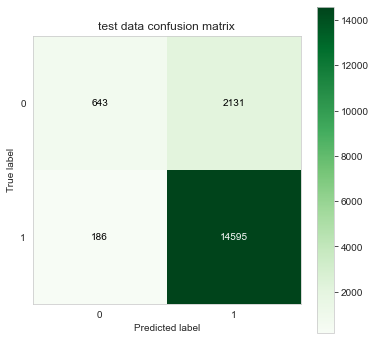

In [132]:
test(tfidf_sent_vectors_train, tfidf_sent_vectors_test, optimal_estimators)

## [5.2] Applying GBDT using XGBOOST

In [133]:
from xgboost import XGBClassifier


In [136]:
def GBDT_train(x_tr, x_cv,x_test):
    cv_scores = []
    train_scores = []
    depth = [1,2,5,10,15,20]
    estimators = [10,20,50,100,150,200]
    
    for d in tqdm(depth):
        for e in estimators:
            clf = XGBClassifier(n_estimators = e, max_depth = d, booster = 'gbtree')
            clf.fit(x_tr,y_train)
            cv_proba = clf.predict_proba(x_cv)[:,1]
            train_proba = clf.predict_proba(x_tr)[:,1]
            cv_score = roc_auc_score(y_cv,cv_proba)
            train_score = roc_auc_score(y_train,train_proba)
            cv_scores.append(cv_score)
            train_scores.append(train_score)
            
    cv_scores = np.array(cv_scores)
    cv_scores = cv_scores.reshape((len(depth), len(estimators)))
    train_scores = np.array(train_scores)
    train_scores = train_scores.reshape((len(depth), len(estimators)))
    
    sns.set_style("whitegrid")
    plt.figure(figsize = (6,6))
    sns.heatmap(train_scores,cmap = "coolwarm", annot = True, xticklabels=estimators, yticklabels=depth)
    plt.xlabel("number of estimators")
    plt.ylabel("max_depth")
    plt.title("Training Data roc auc scores")
    plt.show()
    
    plt.figure(figsize = (6,6))
    sns.heatmap(cv_scores,cmap = "coolwarm", annot = True, xticklabels=estimators, yticklabels=depth)
    plt.xlabel("number of estimators")
    plt.ylabel("max_depth")
    plt.title("CV Data roc auc scores")
    plt.show()
    
    print("Maximum CV score is" , np.amax(cv_scores))
    indexes = np.where(cv_scores == np.amax(cv_scores))
    optimal_depth = depth[int(indexes[0])]
    optimal_estimators = estimators[int(indexes[1])]
    print("Optimal value of max_depth is %d and n_estimators is %d "%(optimal_depth,optimal_estimators))
    
    return optimal_depth, optimal_estimators


In [138]:
def GBDT_test(x_tr,x_tst,optimal_depth,optimal_estimators):
    clf = XGBClassifier(n_estimators = optimal_estimators, booster = 'gbtree',max_depth= optimal_depth)
    clf.fit(x_tr,y_train)
    
    train_proba = clf.predict_proba(x_tr)
    test_proba = clf.predict_proba(x_tst)
    test_score = roc_auc_score(y_test, test_proba[:,1])
    train_score = roc_auc_score(y_train, train_proba[:,1])
    fpr,tpr,thresholds = roc_curve(y_test,test_proba[:,1])
    fpr1,tpr1,thresholds = roc_curve(y_train, train_proba[:,1])
    
    print("Train data AUC score ", train_score)
    print("Test data AUC score", test_score)
    
    # plotting ROC curve
    #plot no skill
    sns.set_style("whitegrid")
    plt.plot([0,1],[0,1],'b--')
    plt.plot(fpr,tpr,label = "Test ROC curve" + str(test_score))
    plt.plot(fpr1, tpr1, label = "Train ROC curve" + str(train_score))
    plt.title("ROC curve for train and test data")
    plt.ylabel("True Postive Rates")
    plt.xlabel("False Positive Rates")
    plt.legend()
    plt.show()
    
    #plotting confusion matrix
    y_pred = clf.predict(x_tst)
    plot_confusion_matrix(y_test,y_pred,cmap = "Greens", figsize = (6,6))
    plt.title("test data confusion matrix")
    plt.show()

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

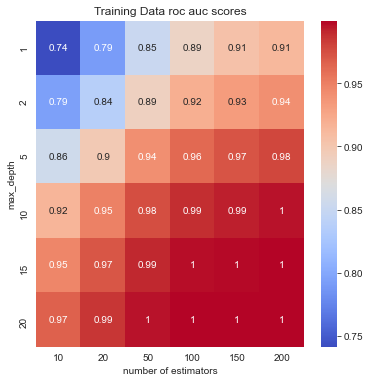

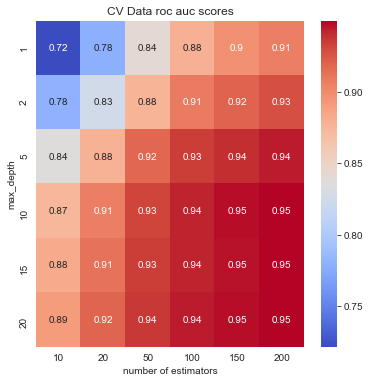

Maximum CV score is 0.949598763521033
Optimal value of max_depth is 20 and n_estimators is 200 


In [137]:
optimal_depth,optimal_estimators = GBDT_train(train_bow, cv_bow, test_bow)

Train data AUC score  0.999847872852806
Test data AUC score 0.9526567944866965


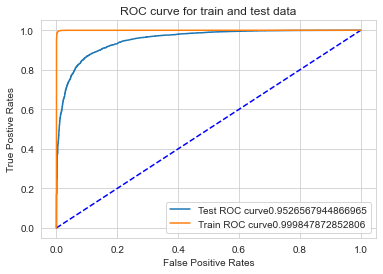

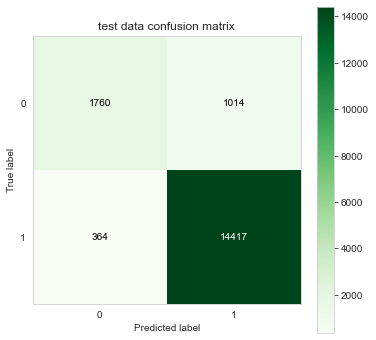

In [139]:
GBDT_test(train_bow,test_bow,optimal_depth, optimal_estimators)

In [142]:
feature_names = count_vect.get_feature_names()
clf = XGBClassifier(n_estimators = optimal_estimators ,max_depth = optimal_depth,booster = 'gbtree')
clf.fit(train_bow, y_train)
feat_importance = clf.feature_importances_
feat_dict = dict(zip(feat_importance,feature_names))
feat_importance = sorted(feat_importance, reverse = True)
importance = []
words = []
for imp in feat_importance[0:20]:
    words.append(feat_dict[imp])
    importance.append(imp) 

In [143]:
print("Top 20 features are :")
print("%30s\t%30s"%("feature_names","feature_importance"))
print('*'*100)
for i in range(20):
    print('%30s\t\t\t%.10f'%(words[i],importance[i]))

Top 20 features are :
                 feature_names	            feature_importance
****************************************************************************************************
                        return			0.0054955524
              not disappointed			0.0052467552
                       perfect			0.0049786177
                         worst			0.0048315143
                       not buy			0.0047481279
                     delicious			0.0041975635
                         waste			0.0038184400
                         awful			0.0037855078
                   waste money			0.0033452439
                     not worth			0.0033211350
                 not recommend			0.0032889983
                      horrible			0.0031429094
                 disappointing			0.0030632645
                     wonderful			0.0030406385
                      terrible			0.0030392108
                        highly			0.0029734792
                    disgusting			0.0027536680
                     excellent			

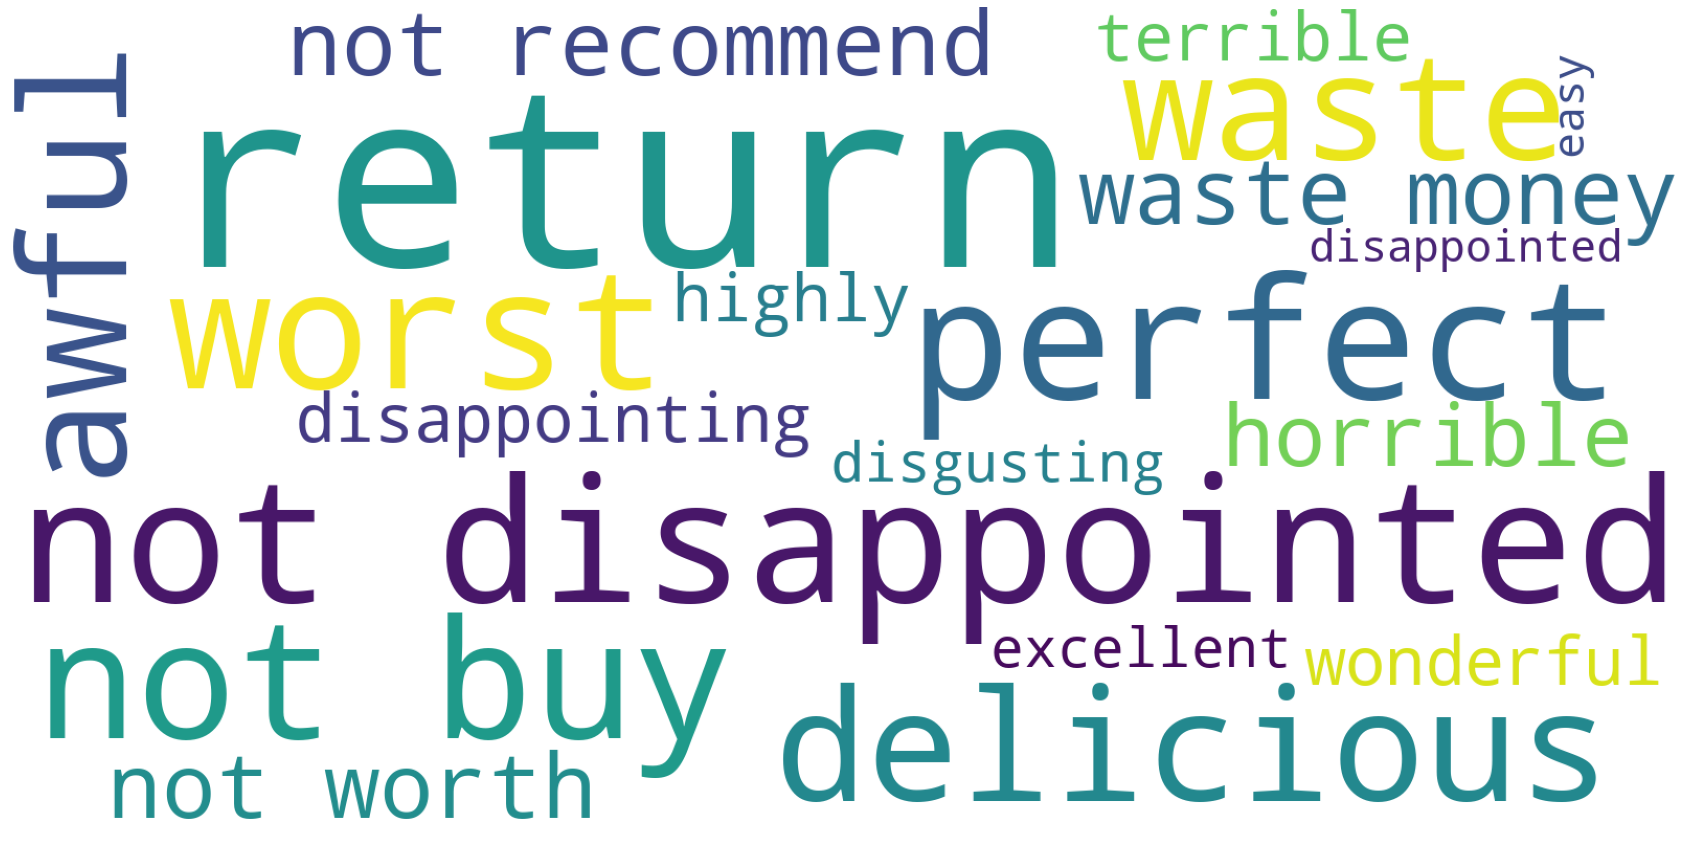

In [144]:
img = WordCloud(background_color = 'white',width = 1600, height = 800, stopwords=[])
img.fit_words(dict(zip(words,importance)))
plt.figure(figsize = (30,20))
plt.axis("off")
plt.imshow(img)
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

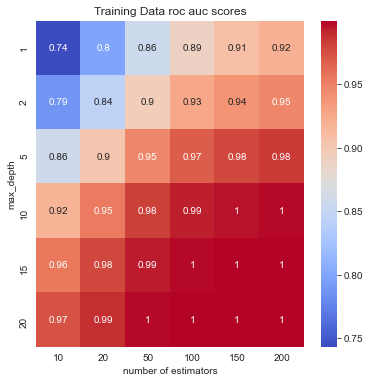

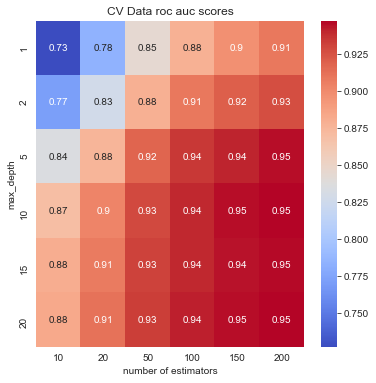

Maximum CV score is 0.9477660712193089
Optimal value of max_depth is 10 and n_estimators is 200 


In [145]:
optimal_depth,optimal_estimators = GBDT_train(train_tfidf, cv_tfidf,test_tfidf)

Train data AUC score  0.9982759654702257
Test data AUC score 0.949010223622007


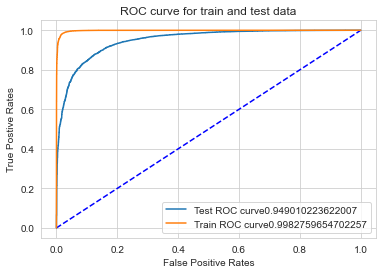

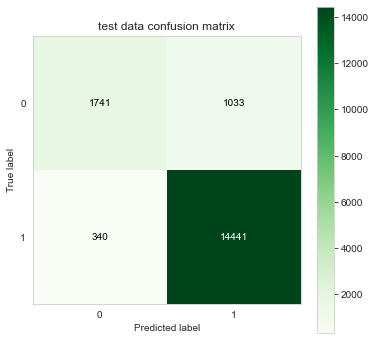

In [146]:
GBDT_test(train_tfidf, test_tfidf, optimal_depth,optimal_estimators)

In [148]:
feature_names = tfidf_vect.get_feature_names()
clf = XGBClassifier(n_estimators = optimal_estimators , n_jobs = -1, max_depth = optimal_depth, booster = 'gbtree')
clf.fit(train_tfidf, y_train)
feat_importance = clf.feature_importances_
feat_dict = dict(zip(feat_importance,feature_names))
feat_importance = sorted(feat_importance, reverse = True)
importance = []
words = []
for imp in feat_importance[0:20]:
    words.append(feat_dict[imp])
    importance.append(imp) 

In [149]:
print("Top 20 features are :")
print("%30s\t%30s"%("feature_names","feature_importance"))
print('*'*100)
for i in range(20):
    print('%30s\t\t\t%.10f'%(words[i],importance[i]))

Top 20 features are :
                 feature_names	            feature_importance
****************************************************************************************************
              not disappointed			0.0075577442
                         worst			0.0073318784
                    disgusting			0.0064754677
                      terrible			0.0063456749
                        return			0.0058888970
                       not buy			0.0055174441
                 disappointing			0.0049937256
                         awful			0.0047376514
                 not recommend			0.0047137747
                      horrible			0.0045794980
                         threw			0.0043286723
                       perfect			0.0041391230
                         waste			0.0040823678
                        beware			0.0040748068
                     delicious			0.0040290644
                     wonderful			0.0040193973
                         money			0.0040184725
                  not purchase			

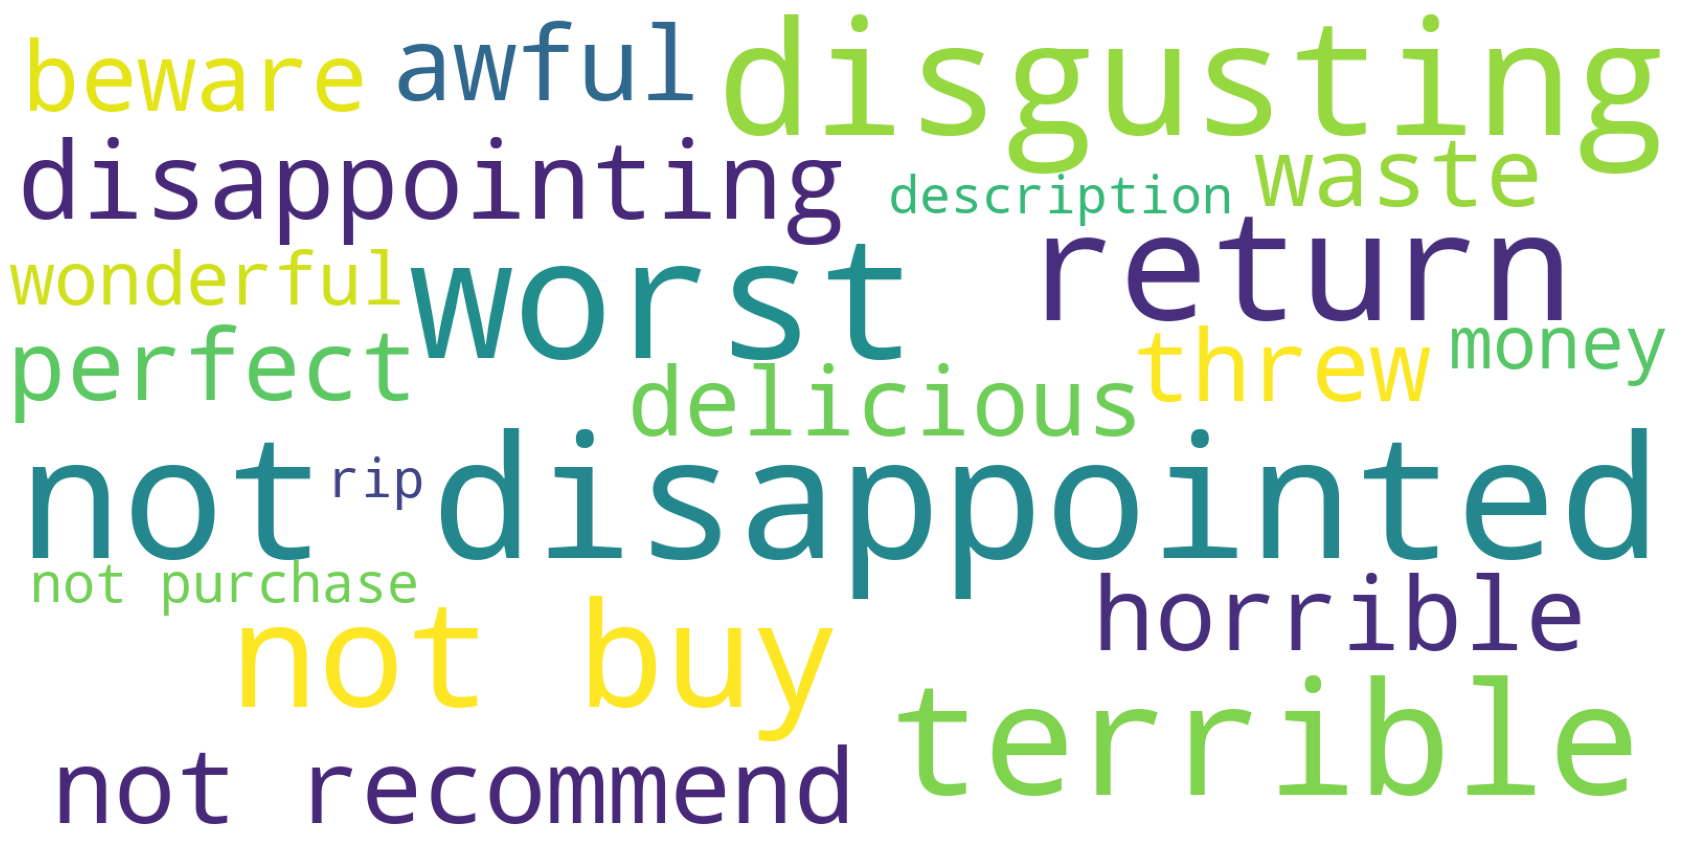

In [150]:
img = WordCloud(background_color = 'white',width = 1600, height = 800, stopwords=[])
img.fit_words(dict(zip(words,importance)))
plt.figure(figsize = (30,20))
plt.axis("off")
plt.imshow(img)
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [152]:
train_w2v = np.array(train_w2v)
cv_w2v = np.array(cv_w2v)
test_w2v = np.array(test_w2v)

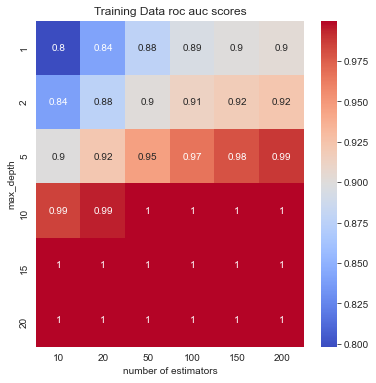

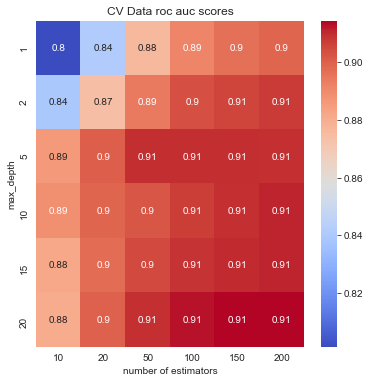

Maximum CV score is 0.914389418316091
Optimal value of max_depth is 20 and n_estimators is 200 


In [153]:
optimal_depth, optimal_estimators = GBDT_train(train_w2v,cv_w2v,test_w2v)

Train data AUC score  0.9999975350794434
Test data AUC score 0.9088056692356323


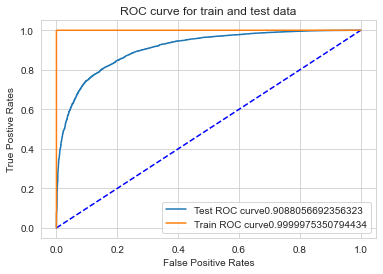

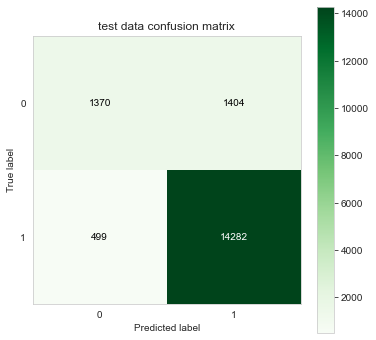

In [154]:
GBDT_test(train_w2v,test_w2v, optimal_depth, optimal_estimators)

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [155]:
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

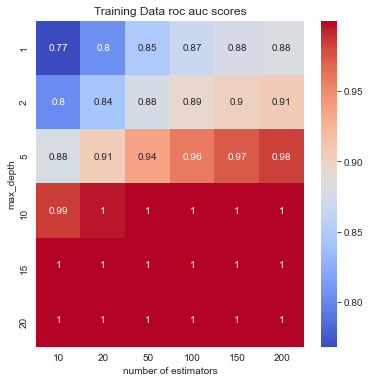

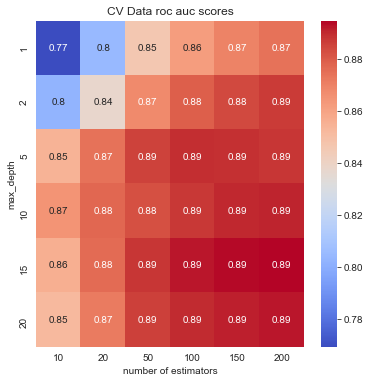

Maximum CV score is 0.8948244757577151
Optimal value of max_depth is 15 and n_estimators is 200 


In [156]:
optimal_depth, optimal_estimators = GBDT_train(tfidf_sent_vectors_train,tfidf_sent_vectors_cv,tfidf_sent_vectors_test)

Train data AUC score  0.9999975152387002
Test data AUC score 0.8911485969609556


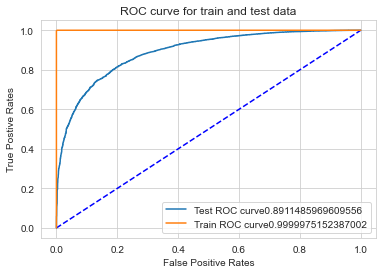

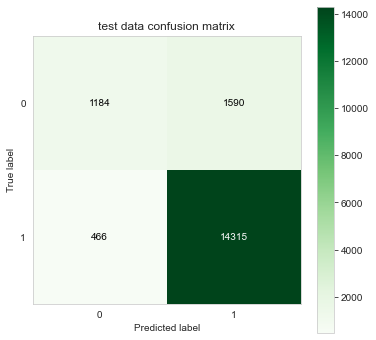

In [157]:
GBDT_test(tfidf_sent_vectors_train, tfidf_sent_vectors_test, optimal_depth, optimal_estimators)

# [6] Conclusions

In [160]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "Hyperparameters", "Test AUC Score"]
table.add_row(["Bag of Words", "Random Forest","n_estimators = 500",0.9429142651664066])
table.add_row(["TF-IDF", "Random Forest", "n_estimators = 300",0.9436417940820868])
table.add_row(["Average Word2Vec", "Random Forest", "n_estimators = 300", 0.8997603170187648])
table.add_row(["TF-IDF weighted Word2Vec", "Random Forest", "n_estimators = 400",0.878857039769337])
table.add_row(["Bag of Words", "XGBoost","max_depth = 20 and n_estimators = 200",0.9526567944866965])
table.add_row(["TF-IDF", "XGBoost", "max_depth = 10 and n_estimators = 200", 0.949010223622007])
table.add_row(["Average Word2Vec", "XGBoost", "max_depth = 20 and n_estimators = 200",0.9088056692356323])
table.add_row(["TF-IDF weighted Word2Vec", "XGBoost", "max_depth = 15 and n_estimators = 200",0.8911485969609556])
print(table)

+--------------------------+---------------+---------------------------------------+--------------------+
|        Vectorizer        |     Model     |            Hyperparameters            |   Test AUC Score   |
+--------------------------+---------------+---------------------------------------+--------------------+
|       Bag of Words       | Random Forest |           n_estimators = 500          | 0.9429142651664066 |
|          TF-IDF          | Random Forest |           n_estimators = 300          | 0.9436417940820868 |
|     Average Word2Vec     | Random Forest |           n_estimators = 300          | 0.8997603170187648 |
| TF-IDF weighted Word2Vec | Random Forest |           n_estimators = 400          | 0.878857039769337  |
|       Bag of Words       |    XGBoost    | max_depth = 20 and n_estimators = 200 | 0.9526567944866965 |
|          TF-IDF          |    XGBoost    | max_depth = 10 and n_estimators = 200 | 0.949010223622007  |
|     Average Word2Vec     |    XGBoost    | m